# Data Processing Constant Current Cycling (CCC) for Electrochromic 3-Electrode Testing

**Created by Robert Black, Dec 2021**

**Utilizing Data collected By Fae Habib Zadeh in Dec 2021**
<p>The following notebook is for the extraction and post-processing of electrochromic data acquired via a 3 electrode cell.

This notebook was created utilizing data collected in Dec 2021 under the following conditions:
- Constant Current Cycling

In brief, this notebook performs the following:
- Import of both the electrochemical and spectrometer data into a dataframe
- Curation of the raw data to pull important metrics (delta voltage, delta charge, and OD vs. cycle number) that can be used as a metric of performance

This notebook serves as a tool post-process the data collected, and likely will have to be modified
for deployment on the robotic platform once it is known the exact data collection method as part of the experimental workflow.</p>

In [131]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import json
import pickle
from scipy import integrate

**Initial dictionary intilization and population with data**

Below is an example of the data structure:
dict_ID = {exp1:{info:[data],echem:[data],spectro:[data],metric:[data]}}

The variable **'total_expts'** below has the user define how many experiments are expected to be performed. If unknown, an arbitrarily large number can be set. On the platform, this number will just be high (100+).

The outcome will be the generation of a dictionary, to which all curated data will be stored and saved as part of a data structure.

In [132]:
# Initial dictionary creation
dict = {}
total_expts = 50 # Update me based on the number of expected experiments to run
for i in range(1,total_expts):
  dict[f'exp{i}'] = {'info':{},'echem':{},'spectro':{},'metrics':{}}

**Import Data**

The following will import the raw electrochemical and spectro data and store into the above defined data structure.

IMPORTANT! This will likely have to be modified to fit the corresponding raw data files - adjust field names as necessary!

The following is an example of a single data import of the following files:
- 'EXP1 ECHEM.txt' --> Electrochemical Data
- 'EXP1.N943B1 - null, time, CIEX, CIEY, CIEZ, L, a b, HL, Ha, Hb, AbsTHr.txt' --> Spectral Data

**Populate Info**<br>
duration = From the experiment the duration of each cycle is known **[in seconds]**<br>
I = From the experiment the current is known **[in mA]**<br>
current_exp = Current experiment index **[number]**<br>

**Note - this information will be autopopulated when run in-line with the automated platform **

In [133]:
def import_data(current_exp_num,echem,spectro,duration,I,SA):
    global current_exp # Note here is where the user defines the current_exp_num, which carries on throughout the code and hence is a global variable
    current_exp = current_exp_num # See above comment
    # Populate electrochemical data (assumes data is in same directory):
    dict[f'exp{current_exp}']['echem'] = pd.read_csv(f'{echem}', delimiter =';')

    # Populate spectro:
    a = np.genfromtxt(f'{spectro}', delimiter=',')
    dict[f'exp{current_exp}']['spectro'] = pd.DataFrame(a[:,1:11], columns = ['time','CIEX', 'CIEY', 'CIEZ', 'L', 'a b', 'HL', 'Ha', 'Hb', 'AbsTHr'])
    
    dict[f'exp{current_exp}']['info']['duration'] = duration
    dict[f'exp{current_exp}']['info']['I'] = I
    dict[f'exp{current_exp}']['info']['SA'] = SA
    
# Example of importing the experiment 1 data and associated experimental parameters
import_data(1,'EXP1 ECHEM.txt','EXP1.N943B1 - null, time, CIEX, CIEY, CIEZ, L, a b, HL, Ha, Hb, AbsTHr.txt',60,10,(2.5*1.7))

**Electrochemical data curation and metric extraction**

The following function extracts the critical information from the electrochemical dataframe:

a) Charge extraction from each cycle (+ / -)

b) Associated voltage from each cycle (+ / - / delta)

This extraction puts the values into '+' & '-' portions corresponding to positive applied current and a negative applied current.

This information will be necessary to determine optical density, as well as understand the stability of the 
electrochromic film.

Plots are also generated as part of this notebook.

The function inputs are:<br> 
- Raw electrochemical table <br> 
- Duration of each cycle

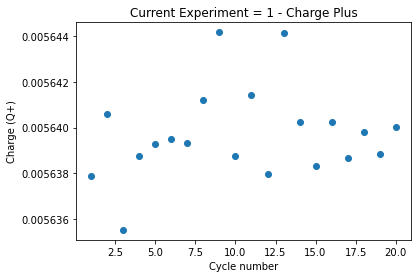

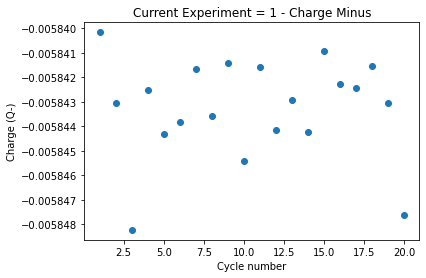

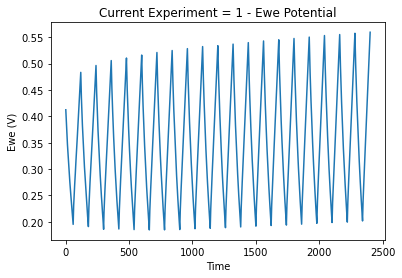

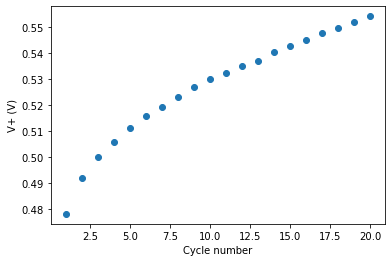

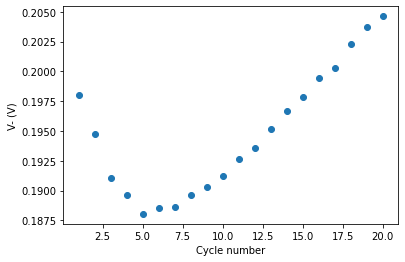

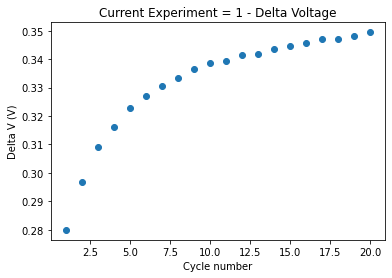

In [134]:
def electrochem_process(data = dict[f'exp{current_exp}']['echem'], duration = dict[f'exp{current_exp}']['info']['duration']):

  #CHARGE EXTRACTION
  #Extract the total + and - charge based on the current passed
  cycle = np.linspace(1,40, num = 40) # change 'num' based on total number of cycles
  charge = np.zeros(40)
  #duration =  #60# int(dict[f'exp{current_exp}']['info']['duration']) # info added previously by user 
  for j in range(0,40): # This loop separates the data based on number of cycles through the use of the known time duration of each cycle
    t = data.iloc[(j*(duration-1)):((j*(duration-1))+(duration-1))-1]['Corrected time (s)']
    I = data.iloc[(j*(duration-1)):((j*(duration-1))+(duration-1))-1]['WE(1).Current (A)']
    y_int = integrate.cumtrapz(I, t, initial=0) # calculation of charge through integration
    charge[j] = y_int[-1]

  #Note that this puts it into the +,-,+,- format, for only + need to grab every second value
  cycle_plus = np.linspace(1,20, num = 20) 
  charge_plus = np.zeros(int(len(cycle)/2))
  for i in range(len(cycle)):
    if i in np.linspace(1,41, num = 21): #1,3,5 etc. 
      k = int((i-1)/2)
      charge_plus[k] = charge[i]
  plt.scatter(cycle_plus,charge_plus)
  plt.ylabel('Charge (Q+)')
  plt.xlabel('Cycle number')
  plt.title(f'Current Experiment = {current_exp} - Charge Plus')
  plt.show()

  #Note that this puts it into the +,-,+,- format, for only - need to grab every second value
  cycle_minus = np.linspace(1,20, num = 20) 
  charge_minus = np.zeros(int(len(cycle)/2))
  for i in range(len(cycle)):
    if i in np.linspace(0,40, num = 21): #0,2,4 etc. 
      if i == 0:
        k = int((i-1)/2)
      else:
        k = int((i-1)/2)+1
      charge_minus[k] = charge[i]
  plt.scatter(cycle_minus,charge_minus)
  plt.ylabel('Charge (Q-)')
  plt.xlabel('Cycle number')
  plt.title(f'Current Experiment = {current_exp} - Charge Minus')
  plt.show()

  #VOLTAGE EXTRACTION
  #Extract the negative, positive, and delta of the voltage
  voltage_minus = np.zeros(int(len(cycle)/2))
  voltage_plus = np.zeros(int(len(cycle)/2))
  voltage_delta = np.zeros(int(len(cycle)/2))
  voltage = np.zeros(40)
  for j in range(0,40):
    voltage[j] = np.array(data.iloc[(j*(duration-1)):((j*(duration-1))+(duration-1))-1]['WE(1).Potential (V)'])[-1] # Take the last value as the 'peak' is what we care about
  for i in range(len(cycle)): # To grab all the - current values
      if i in np.linspace(0,40, num = 21): #0,2,4 etc. 
        if i == 0:
          k = int((i-1)/2)
        else:
          k = int((i-1)/2)+1
        voltage_minus[k] = voltage[i]
  for i in range(len(cycle)): # To grab all the + current values
    if i in np.linspace(1,41, num = 21): #1,3,5 etc. 
      k = int((i-1)/2)
      voltage_plus[k] = voltage[i]
  voltage_delta = voltage_plus-voltage_minus

  # Below are various plots produced with the data to check results - can be changed as necessary depending on the desired information
  plt.plot(data['Time (s)'],data['WE(1).Potential (V)'])
  plt.ylabel('Ewe (V)')
  plt.xlabel('Time')
  plt.title(f'Current Experiment = {current_exp} - Ewe Potential')
  plt.show()

  plt.scatter(cycle_minus,voltage_plus)
  plt.ylabel('V+ (V)')
  plt.xlabel('Cycle number')
  plt.show()

  plt.scatter(cycle_minus,voltage_minus)
  plt.ylabel('V- (V)')
  plt.xlabel('Cycle number')
  plt.show()

  plt.scatter(cycle_minus,voltage_delta)
  plt.ylabel('Delta V (V)')
  plt.xlabel('Cycle number')
  plt.title(f'Current Experiment = {current_exp} - Delta Voltage')
  plt.show()

  # Updating the datastructure to include the metrics
  dict[f'exp{current_exp}']['metrics']['cycle'] = cycle_plus
  dict[f'exp{current_exp}']['metrics']['charge_plus'] = charge_plus
  dict[f'exp{current_exp}']['metrics']['charge_minus'] = charge_minus
  dict[f'exp{current_exp}']['metrics']['voltage_delta'] = voltage_delta
  dict[f'exp{current_exp}']['metrics']['voltage_plus'] = voltage_plus
  dict[f'exp{current_exp}']['metrics']['voltage_minus'] = voltage_minus

# Run the function
electrochem_process()

**If necessary, spectral data alignment**

Prior to extracting the spectral data, a small time offset may be required due to de-syncing of the electrochemical measurements with the spectrometer.

On the robot platform the exact potentiostat-spectrometer communications will be set, so this step will likely not be performed.

Regardless, below is a function to manually apply the time correction

In [135]:
def spectro_time_correction(data, time_correction):
  data['time'] = data['time']- time_correction
  data['time'] = data['time'][(data['time']<2400) & (data['time']>0)]

spectro_time_correction(data = dict[f'exp{current_exp}']['spectro'], time_correction = 12 )

***Spectrometer Data Extraction***

Need to take the CIEY at top and bottom of each cycle and extract that information to obtain the metrics of deltaT:

- Obtain Tb and Td

- Use to get DeltaT

- Plot vs. cycle number

- Use to get colouration efficiency

**TODO: What about the cycle number, easier way to integrate?**

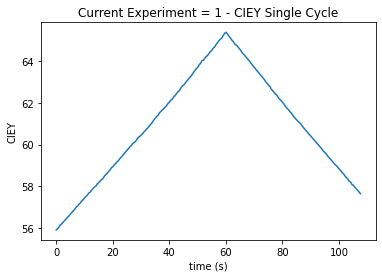

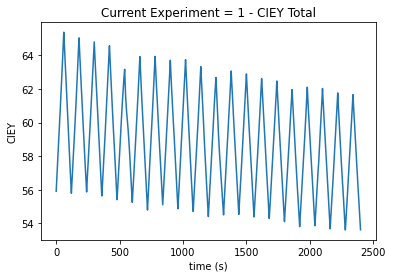

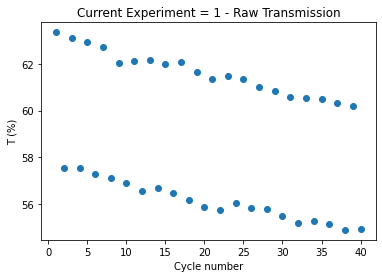

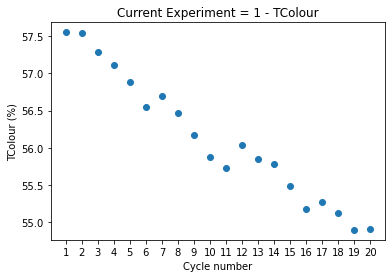

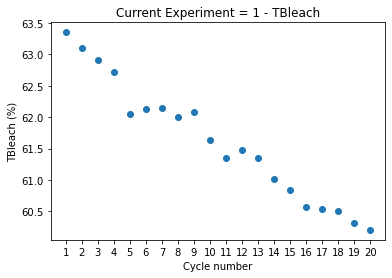

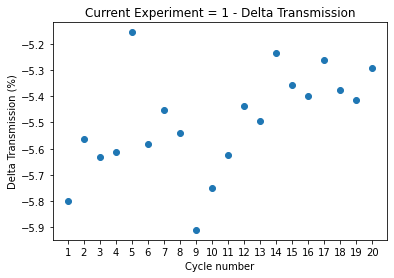

In [136]:
def spectro_process(data = dict[f'exp{current_exp}']['spectro'], duration = dict[f'exp{current_exp}']['info']['duration']):
  step = duration*2 # Need to add this because the time interval is 0.5 s
  plt.plot(data['time'][:step*2],data['CIEY'][:step*2])
  plt.ylabel('CIEY')
  plt.xlabel('time (s)')
  plt.title(f'Current Experiment = {current_exp} - CIEY Single Cycle')
  plt.show()
  plt.plot(data['time'],data['CIEY'])
  plt.ylabel('CIEY')
  plt.xlabel('time (s)')
  plt.title(f'Current Experiment = {current_exp} - CIEY Total')
  plt.show()

  cycle = np.linspace(1,40, num = 40)
  T = np.zeros(40)
  for j in range(0,40):
    T[j] = data['CIEY'][step+(step*j)]
  plt.scatter(cycle, T)
  plt.ylabel('T (%)')
  plt.xlabel('Cycle number')
  plt.title(f'Current Experiment = {current_exp} - Raw Transmission')
  plt.show()

  #Note that this puts it into the +,-,+,- format + need to grab every second value
  cycle_plus = np.linspace(1,20, num = 20) # change 'num' based on total number of cycles
  T_c = np.zeros(int(len(cycle)/2))
  for i in range(len(cycle)):
    if i in np.linspace(1,41, num = 21): #1,3,5 etc. 
      k = int((i-1)/2)
      T_c[k] = T[i]
  plt.scatter(cycle_plus,T_c)
  plt.ylabel('TColour (%)')
  plt.xlabel('Cycle number')
  plt.xticks(np.arange(min(cycle_plus), max(cycle_plus)+1, 1.0))
  plt.title(f'Current Experiment = {current_exp} - TColour')
  plt.show()

  #Note that this puts it into the +,-,+,- format - need to grab every second value
  cycle_minus = np.linspace(1,20, num = 20) # change 'num' based on total number of cycles
  T_b = np.zeros(int(len(cycle)/2))
  for i in range(len(cycle)):
    if i in np.linspace(0,40, num = 21): #0,2,4 etc. 
      if i == 0: # This is due to the int() function making k = 0 for i = 0 and 1 - so adjusted to ensure if i = 0 get zero
        k = int((i-1)/2)
      else:
        k = int((i-1)/2)+1 # Had to add +1 for all i != 0 to get the right index here
      T_b[k] = T[i]
  #print(T_b)
  plt.scatter(cycle_minus,T_b)
  plt.ylabel('TBleach (%)')
  plt.xlabel('Cycle number')
  plt.xticks(np.arange(min(cycle_minus), max(cycle_minus)+1, 1.0))
  plt.title(f'Current Experiment = {current_exp} - TBleach')
  plt.show()

  T_delta = T_c-T_b
  plt.scatter(cycle_plus,T_delta)
  plt.ylabel('Delta Transmission (%)')
  plt.xlabel('Cycle number')
  plt.xticks(np.arange(min(cycle_minus), max(cycle_minus)+1, 1.0))
  plt.title(f'Current Experiment = {current_exp} - Delta Transmission')
  plt.show()

  dict[f'exp{current_exp}']['metrics']['T_c'] = T_c
  dict[f'exp{current_exp}']['metrics']['T_b'] = T_b
  dict[f'exp{current_exp}']['metrics']['delta_T'] = T_delta

spectro_process()

**Visualization of optical density**

Below is the code to look at Tb & Tc and get the OD as metric data

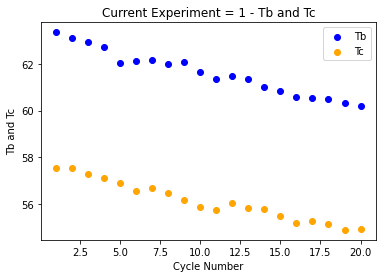

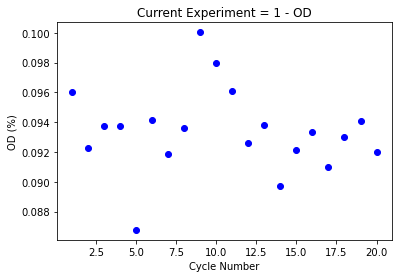

In [137]:
def optical_density():
    plt.scatter(dict[f'exp{current_exp}']['metrics']['cycle'],dict[f'exp{current_exp}']['metrics']['T_b'], color = 'blue', label = 'Tb')
    plt.scatter(dict[f'exp{current_exp}']['metrics']['cycle'],dict[f'exp{current_exp}']['metrics']['T_c'], color = 'orange', label = 'Tc')
    plt.legend()
    plt.xlabel('Cycle Number')
    plt.ylabel ('Tb and Tc')
    plt.title(f'Current Experiment = {current_exp} - Tb and Tc')
    plt.show()

    dict[f'exp{current_exp}']['metrics']['OD'] = np.log(dict[f'exp{current_exp}']['metrics']['T_b']/dict[f'exp{current_exp}']['metrics']['T_c'])

    plt.scatter(dict[f'exp{current_exp}']['metrics']['cycle'],dict[f'exp{current_exp}']['metrics']['OD'], color = 'blue')
    plt.xlabel('Cycle Number')
    plt.ylabel ('OD (%)')
    plt.title(f'Current Experiment = {current_exp} - OD')
    plt.show()
optical_density()

**Data Storage**

Finally, the data is saved and the next experiment can be run:

In [138]:
# Save the data file
def save_data():
    with open('Workflow1_Example.pkl', 'wb') as f:
        pickle.dump(dict, f)

# Post-processing of subsequent data

The initial post-processing algorithm above analyzes a single experiment. The functions generated from the above code can now be used for simple processing, curation, and storage of subsequent experiments.<br>

Below is an example for experiment 4 & experiment 5 data.

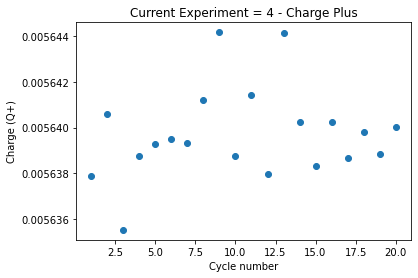

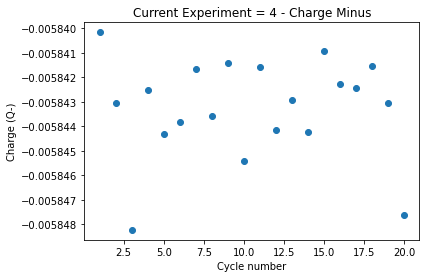

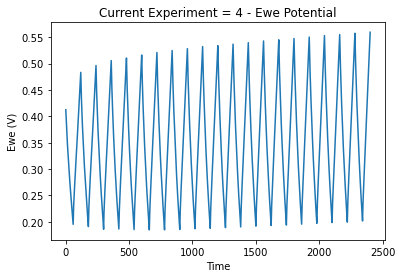

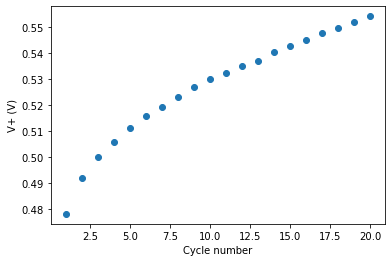

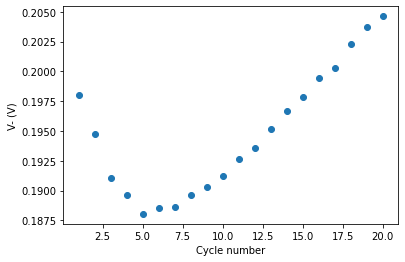

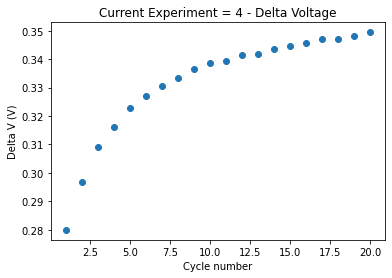

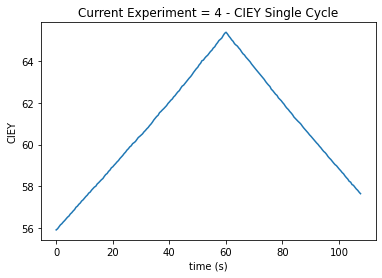

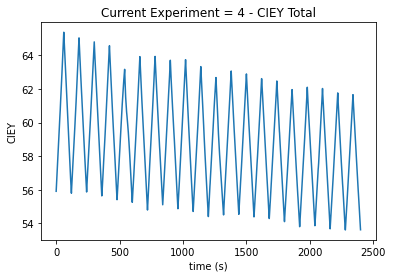

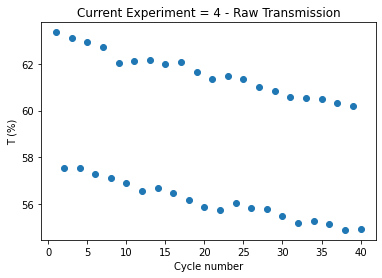

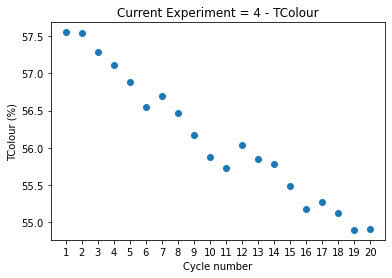

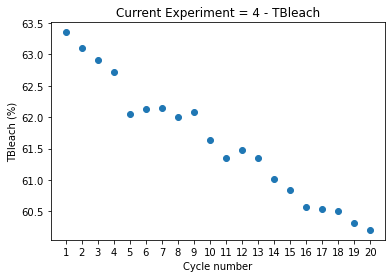

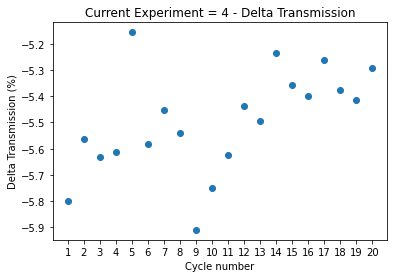

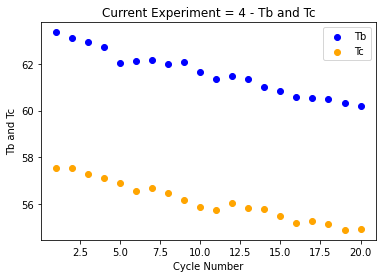

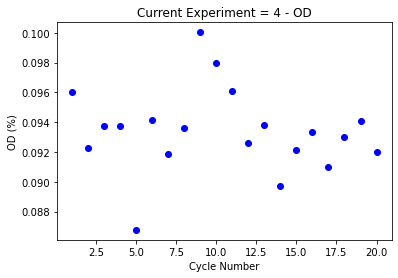

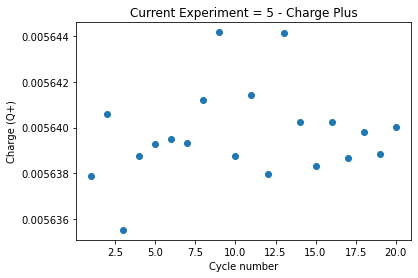

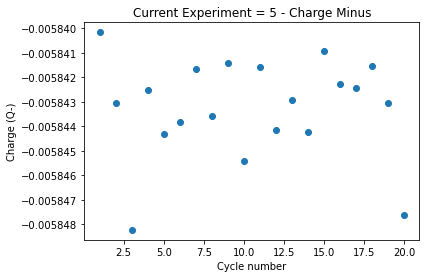

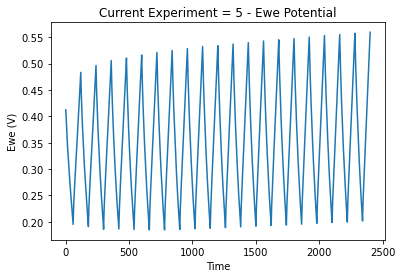

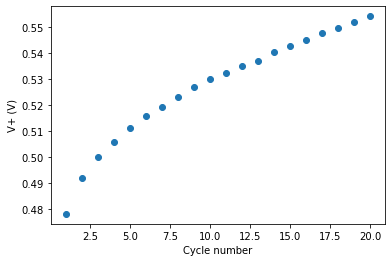

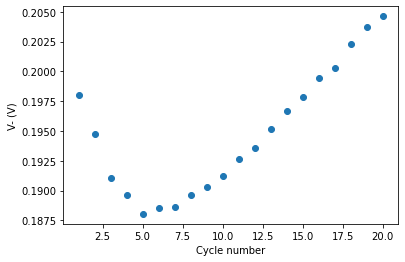

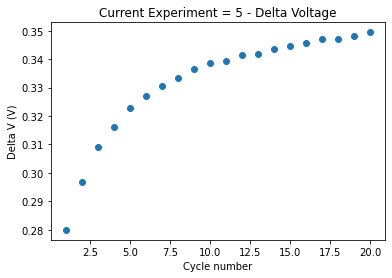

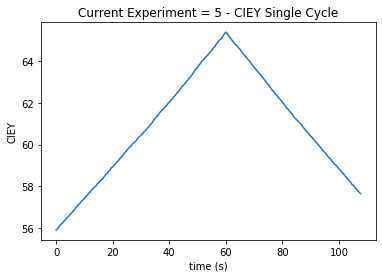

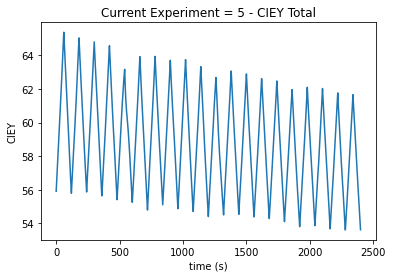

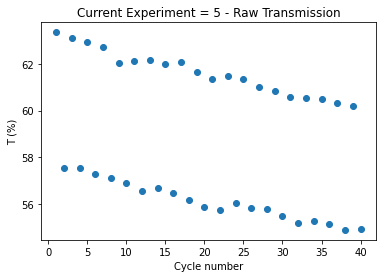

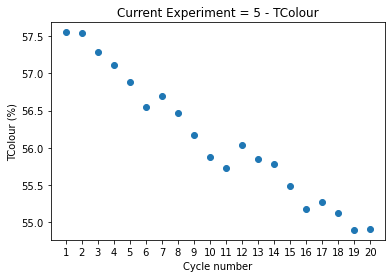

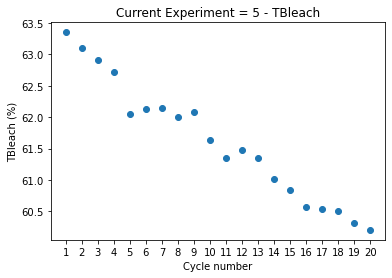

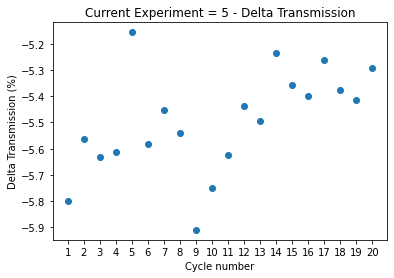

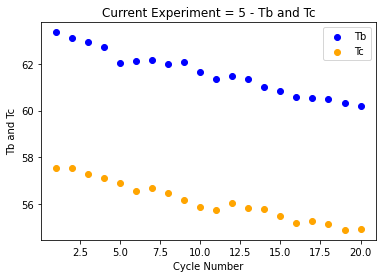

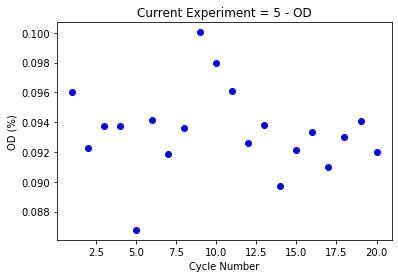

In [139]:
import_data(4,'EXP4 ECHEM.txt','EXP4.N943B4 - null, time, CIEX, CIEY, CIEZ, L, a b, HL, Ha, Hb, AbsTHr_3.txt',30,10,(2.5*1.6))
electrochem_process()
spectro_time_correction(data = dict[f'exp{current_exp}']['spectro'],time_correction = 8)
spectro_process()
optical_density()
save_data()

import_data(5,'EXP5 ECHEM.txt','EXP5.N943B5 - null, time, CIEX, CIEY, CIEZ, L, a b, HL, Ha, Hb, AbsTHr_1.txt',30,50,(2.5*1.6))
electrochem_process()
spectro_time_correction(data = dict[f'exp{current_exp}']['spectro'], time_correction = 6.5)
spectro_process()
optical_density()
save_data()